In [2]:
!nvidia-smi

Thu Nov 11 13:27:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Modules

In [3]:
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.cuda import is_available
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

%matplotlib inline

In [4]:
device='cuda' if is_available() else 'cpu'
device

'cuda'

# Download data

In [5]:
transform=transforms.Compose([transforms.Resize((32,32)),
                              transforms.ToTensor()])

all_data=MNIST(root='.',train=True,transform=transform,download=True)

train_ratio=0.8
train_data_len=int(len(all_data)*0.8)
valid_data_len=len(all_data)-train_data_len

train_data,valid_data=random_split(all_data,[train_data_len,valid_data_len])
test_data=MNIST(root='.',train=False,transform=transform,download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


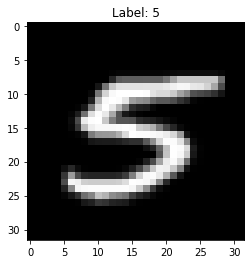

In [6]:
img=transforms.ToPILImage()(train_data[0][0])

plt.title('Label: {}'.format(train_data[0][1]))
plt.imshow(img,cmap='gray')

# Define a Model

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.c1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.s2=nn.AvgPool2d(kernel_size=2)
        self.c3=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.s4=nn.AvgPool2d(kernel_size=2)
        self.c5=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)
        self.f6=nn.Linear(in_features=120,out_features=84)
        self.f7=nn.Linear(in_features=84,out_features=10)

    def forward(self,x):
        x=self.c1(x)
        x=self.s2(x)
        x=self.c3(x)
        x=self.s4(x)
        x=self.c5(x).view(-1,120)
        x=self.f6(x)
        x=self.f7(x)
        return x

# Prepare training step

In [8]:
batch_size=128

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_data,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [9]:
model=LeNet5()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

model=model.to(device)
criterion=criterion.to(device)

# Train and validation

In [10]:
num_epochs=10
patience=0
early_stop=3
max_acc=-np.inf

for epoch in range(num_epochs):
    train_loss=0
    train_acc=0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        data,label=data.to(device),label.to(device)
        pred=model(data)
        loss=criterion(pred,label)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        train_acc+=pred.argmax(axis=1).eq(label).sum()
    train_loss/=len(train_data)
    train_acc=train_acc.cpu().item()/len(train_data)
    print('Training Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,train_loss,train_acc*100))
    valid_loss=0
    valid_acc=0
    model.eval()
    with torch.no_grad():
        for data,label in valid_loader:
            data,label=data.to(device),label.to(device)
            pred=model(data)
            loss=criterion(pred,label)
            valid_loss=loss.item()*data.size(0)
            valid_acc+=pred.argmax(axis=1).eq(label).sum()
        valid_loss/=len(valid_data)
        valid_acc=valid_acc.cpu().item()/len(valid_data)
        print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.2f}%'.format(epoch,valid_loss,valid_acc*100))
        if valid_acc>max_acc:
            max_acc=valid_acc
            patience=0
        else:
            patience+=1
        if patience>=early_stop:
            print('Train finished by early stopping')
            break

Training Epoch 0 - Loss : 0.50119064 Accuracy : 84.98%
Validation Epoch 0 - Loss : 0.00183651 Accuracy : 89.09%
Training Epoch 1 - Loss : 0.34833686 Accuracy : 89.92%
Validation Epoch 1 - Loss : 0.00200061 Accuracy : 90.03%
Training Epoch 2 - Loss : 0.33567811 Accuracy : 90.38%
Validation Epoch 2 - Loss : 0.00163071 Accuracy : 90.42%
Training Epoch 3 - Loss : 0.32526548 Accuracy : 90.72%
Validation Epoch 3 - Loss : 0.00169946 Accuracy : 90.47%
Training Epoch 4 - Loss : 0.32426046 Accuracy : 90.77%
Validation Epoch 4 - Loss : 0.00151389 Accuracy : 91.38%
Training Epoch 5 - Loss : 0.31731363 Accuracy : 90.95%
Validation Epoch 5 - Loss : 0.00169755 Accuracy : 91.37%
Training Epoch 6 - Loss : 0.31671246 Accuracy : 90.95%
Validation Epoch 6 - Loss : 0.00176035 Accuracy : 90.95%
Training Epoch 7 - Loss : 0.31360556 Accuracy : 90.97%
Validation Epoch 7 - Loss : 0.00189488 Accuracy : 91.50%
Training Epoch 8 - Loss : 0.31227881 Accuracy : 91.13%
Validation Epoch 8 - Loss : 0.00143710 Accuracy :

# Test

In [11]:
test_loss=0
test_acc=0

for data,label in test_loader:
    data,label=data.to(device),label.to(device)
    pred=model(data)
    loss=criterion(pred,label)
    test_loss+=loss.item()*data.size(0)
    test_acc+=pred.argmax(axis=1).eq(label).sum()
test_loss/=len(test_data)
test_acc=test_acc.cpu().item()/len(test_data)
print('Test Loss : {:.8f} Accuracy : {:.2f}%'.format(test_loss,test_acc*100))

Test Loss : 0.29634627 Accuracy : 91.74%


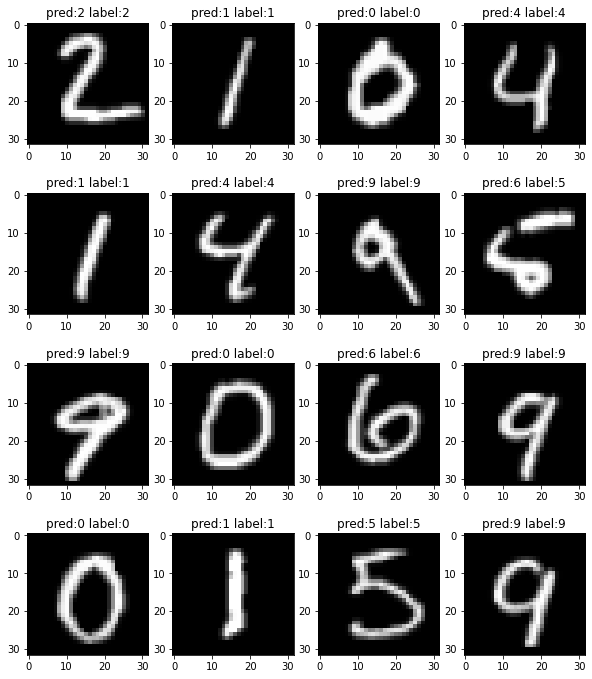

In [12]:
fig=plt.figure(figsize=(10,12))
cols=4
rows=4
for i in range(1,cols*rows+1):
    img=transforms.ToPILImage()(test_data[i][0])
    pred=model(test_data[i][0].unsqueeze(0).to(device))
    fig.add_subplot(rows,cols,i)
    plt.title('pred:{} label:{}'.format(pred.argmax().cpu().item(),test_data[i][1]))
    plt.imshow(img,cmap='gray')
plt.show()